In [3]:
# Weather Prediction using Naive Bayes

# Step 1: Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

In [13]:
import seaborn as sns

In [7]:
# steo 1 : load a dataset from public datasets
df = pd.read_csv('weatherAUS.csv')

In [14]:
# Step 3: Initial Data Exploration
print("First 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
print("\nDataset Info:")
print(df.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am      

In [10]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64


In [11]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [12]:
df.shape

(145460, 23)

In [23]:
import pprint

# Generate a likelihood table for each feature in X with respect to the target y
# We'll use value_counts(normalize=True) for categorical, and mean/std for continuous features

def likelihood_table(X, y):
    table = {}
    target_classes = y.unique()
    for feature in X.columns:
        feature_table = {}
        for cls in target_classes:
            mask = y == cls
            if X[feature].dtype == 'int64' or X[feature].dtype == 'object':
                # For categorical features, show probability of each value
                probs = X.loc[mask, feature].value_counts(normalize=True)
                feature_table[cls] = probs.to_dict()
            else:
                # For continuous features, show mean and std
                vals = X.loc[mask, feature]
                feature_table[cls] = {'mean': vals.mean(), 'std': vals.std()}
        table[feature] = feature_table
    return table

likelihoods = likelihood_table(X, y)
pprint.pprint(likelihoods)

{'Humidity3pm': {np.int64(0): {'mean': np.float64(46.27212341534247),
                               'std': np.float64(18.403691481207115)},
                 np.int64(1): {'mean': np.float64(68.64670485028638),
                               'std': np.float64(18.67371767850719)}},
 'Pressure9am': {np.int64(0): {'mean': np.float64(1018.6113879076856),
                               'std': np.float64(6.766285676339799)},
                 np.int64(1): {'mean': np.float64(1014.3724099180744),
                               'std': np.float64(7.3019326022431565)}},
 'RainToday': {np.int64(0): {0: 0.8466679711234463, 1: 0.15333202887655376},
               np.int64(1): {0: 0.5316102370767781, 1: 0.46838976292322193}},
 'Rainfall': {np.int64(0): {'mean': np.float64(1.2631195740605334),
                            'std': np.float64(5.330194503836653)},
              np.int64(1): {'mean': np.float64(6.121228159211195),
                            'std': np.float64(14.429610525452778)}},
 'Temp3p

In [24]:
from IPython.display import display, HTML

for feature, feature_table in likelihoods.items():
    html = f"<h4>Feature: <b>{feature}</b></h4>"
    # If the value is a dict of dicts (categorical), else mean/std (continuous)
    if isinstance(list(feature_table.values())[0], dict):
        df_feat = pd.DataFrame(feature_table).T.fillna('')
        html += df_feat.to_html()
    else:
        df_feat = pd.DataFrame(feature_table).T
        html += df_feat.to_html()
    display(HTML(html))


,mean,std
0,1.263120,5.330195
1,6.121228,14.429611


,mean,std
0,46.272123,18.403691
1,68.646705,18.673718


,mean,std
0,1018.611388,6.766286
1,1014.372410,7.301933


,mean,std
0,22.608073,6.715023
1,19.416095,6.446941


,0,1
0,0.846668,0.153332
1,0.531610,0.468390


In [15]:
# Step 4: Data Cleaning
# For simplicity, we'll focus on a subset of columns and drop rows with missing values
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'Temp3pm', 'RainToday', 'RainTomorrow']
weather = df[cols].dropna()

# Convert categorical columns to numeric
weather['RainToday'] = weather['RainToday'].map({'No': 0, 'Yes': 1})
weather['RainTomorrow'] = weather['RainTomorrow'].map({'No': 0, 'Yes': 1})

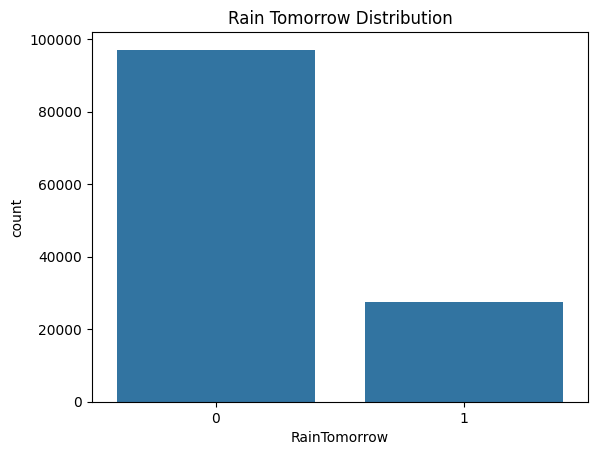

In [16]:
# Step 5: Exploratory Data Analysis (EDA)
# Visualize the distribution of RainTomorrow
sns.countplot(x='RainTomorrow', data=weather)
plt.title('Rain Tomorrow Distribution')
plt.show()



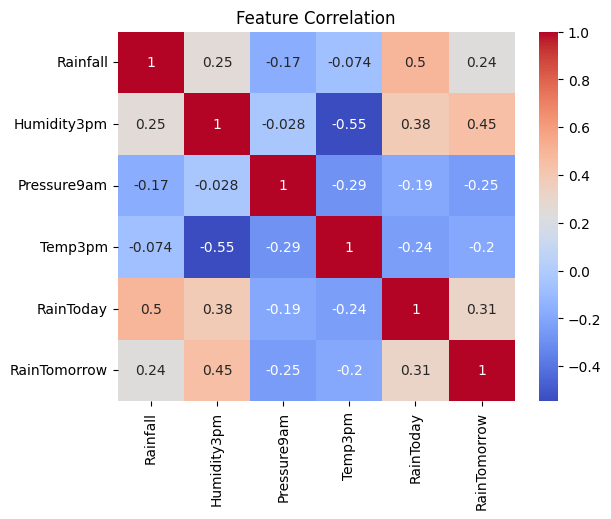

In [17]:
# Correlation heatmap
sns.heatmap(weather.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [18]:
# Step 6: Prepare data for modeling
X = weather.drop('RainTomorrow', axis=1)
y = weather['RainTomorrow']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Step 7: Train Naive Bayes Classifier
model = GaussianNB()
model.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [20]:
# Step 8: Make predictions and evaluate
y_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy Score: 0.8156628438527548

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     19413
           1       0.61      0.46      0.52      5525

    accuracy                           0.82     24938
   macro avg       0.73      0.69      0.70     24938
weighted avg       0.80      0.82      0.81     24938


Confusion Matrix:
 [[17823  1590]
 [ 3007  2518]]


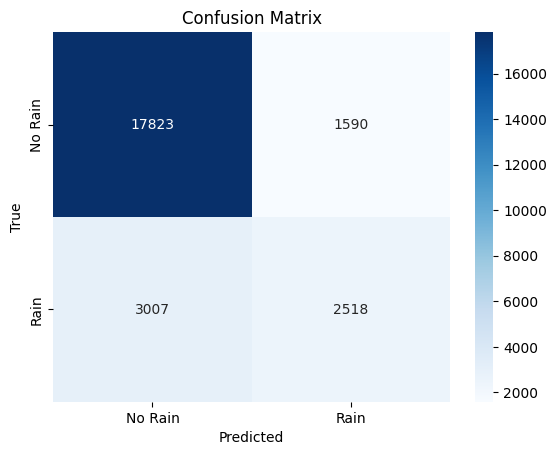

In [21]:
# how to improve the metrics of the model
# Step 9: Visualize the confusion matrix
def plot_confusion_matrix(cm, classes):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['No Rain', 'Rain'])

In [22]:
# Step 10: Improving Model Metrics

# 1. Try adding more features (if available and relevant)
# For example, let's add 'MinTemp' and 'MaxTemp' if they exist and have few missing values
additional_features = ['MinTemp', 'MaxTemp']
available_features = [col for col in additional_features if col in df.columns and df[col].isnull().mean() < 0.1]

if available_features:
    # Prepare a new dataset with additional features
    cols_extended = cols[:-1] + available_features + [cols[-1]]  # keep RainTomorrow at the end
    weather_ext = df[cols_extended].dropna()
    # Convert categorical columns to numeric
    weather_ext['RainToday'] = weather_ext['RainToday'].map({'No': 0, 'Yes': 1})
    weather_ext['RainTomorrow'] = weather_ext['RainTomorrow'].map({'No': 0, 'Yes': 1})
    # Prepare data
    X_ext = weather_ext.drop('RainTomorrow', axis=1)
    y_ext = weather_ext['RainTomorrow']
    X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(X_ext, y_ext, test_size=0.2, random_state=42)
    # Train and evaluate
    model_ext = GaussianNB()
    model_ext.fit(X_train_ext, y_train_ext)
    y_pred_ext = model_ext.predict(X_test_ext)
    print("Accuracy with additional features:", accuracy_score(y_test_ext, y_pred_ext))
    print("\nClassification Report:\n", classification_report(y_test_ext, y_pred_ext))
else:
    print("No additional features with low missing values found. Consider feature engineering or advanced imputation.")

# 2. Try feature scaling (optional for Naive Bayes, but can help in some cases)
# 3. Try other models (e.g., RandomForest, LogisticRegression) for comparison

Accuracy with additional features: 0.8116267865745945

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     19570
           1       0.57      0.47      0.52      5338

    accuracy                           0.81     24908
   macro avg       0.72      0.69      0.70     24908
weighted avg       0.80      0.81      0.80     24908

